# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<b>Objective:-</b>
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
sample_data = filtered_data.head(100000) #Sampled amazon fine foood reviews filtered data to 100k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [12]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'so', "you've", "aren't", 'd', 'whom', 'those', 'doesn', 'i', 'you', "that'll", 'do', 'such', 'from', 'is', "you'll", 'that', 'mightn', 'an', 'myself', 'they', 'should', 'with', 'hadn', 'in', 'hasn', 'wasn', 'into', 'a', 'ma', 'after', 'above', 'on', 've', 'be', 'had', 'o', "you're", 'its', 'own', 'until', "couldn't", 'didn', 'now', "it's", "haven't", 'about', 'yours', 'am', 'what', 'than', "should've", 'won', 'wouldn', 'weren', "wasn't", 'your', 're', 'up', 'don', 'no', 'couldn', 'mustn', "weren't", 'then', 'nor', 'over', 'more', 'ourselves', 'being', 'again', 'all', 'very', "shouldn't", 'not', 'to', 'below', 'further', "shan't", 'y', 'does', 'before', 'and', "doesn't", 'if', 'at', 'shouldn', 'doing', 'them', 'between', 'needn', 't', "mustn't", 'few', 'aren', 'each', 'isn', 'which', 'we', 'once', 'herself', 'most', 'other', 'have', "don't", "won't", "hadn't", 'having', 'how', 'were', 'any', 'off', 'where', 'when', 'too', 'hers', 'haven', 'was', 'can', 'of', 'did', 'has', "isn't", 'hi

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [02:16<00:00, 643.51it/s]


In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

### Sorting dataset based on 'Time' feature

In [15]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(87773, 12)

### Spliting data 

In [16]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [17]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (58807,) (58807,)
X_test, Y_test (28966,) (28966,)
X_tr, Y_tr (39400,) (39400,)
X_cv, Y_cv (19407,) (19407,)


# Training Model with simple CV

In [18]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Training Model for Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
# Random forest classifier
def RF_Classifier(X_train,X_cv,Y_train,Y_cv):
    pred_cv = []
    pred_train = []
    depths = [2, 3, 5, 8, 10, 20]
    estimators = [100, 200, 300, 400, 500]
    for i in depths:
        for j in estimators:
            clf = RandomForestClassifier(n_estimators=j, max_depth=i, n_jobs = -1, class_weight='balanced')
            clf.fit(X_train,Y_train)
            probs = clf.predict_proba(X_cv)
            prob = clf.predict_proba(X_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(Y_cv,probs)
            auc_score_train = roc_auc_score(Y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    cmap=sns.light_palette("green")
    # representing heat map for auc score
    print("-"*30, "AUC Score for train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators,yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()
    print("-"*30, "AUC Score for CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators, yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()    

## Testing Model on Training data and Test data for Random Forest

In [20]:
import scikitplot.metrics as skplt
def testing(X_train,Y_train,X_test,Y_test,optimal_depth,optimal_estimator):
    clf = RandomForestClassifier(n_estimators = optimal_estimator, max_depth = optimal_depth,class_weight='balanced')
    clf.fit(X_train,Y_train)
    prob = clf.predict_proba(X_test) 
    prob1 = clf.predict_proba(X_train)
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    probs1 = prob1[:,1]
    print("AUC Score for train data",roc_auc_score(Y_train,probs1))
    print("AUC Score for test data",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr_train, tpr_train, thresholds = roc_curve(Y_train,probs1)
    fpr_test, tpr_test, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr_test, tpr_test, marker='.',color ='b',label='Test Data')
    plt.plot(fpr_train, tpr_train, marker='.',color= 'r',label='Train Data')
    plt.title("Line Plot of ROC Curve on Train Data and Test Data")
    plt.legend(loc='upper left')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    #plot confusion matrix
    prediction_test=np.argmax(prob,axis=1)
    prediction_train=np.argmax(prob1,axis=1)
    print("macro f1 score for train data :",metrics.f1_score(Y_train, prediction_train, average = 'macro'))
    print("macro f1 score for test data :",metrics.f1_score(Y_test, prediction_test, average = 'macro'))
    print("micro f1 score for train data:",metrics.f1_score(Y_train, prediction_train, average = 'micro'))
    print("micro f1 score for test data:",metrics.f1_score(Y_test, prediction_test, average = 'micro'))
    print("hamming loss for train data:",metrics.hamming_loss(Y_train,prediction_train))
    print("hamming loss for test data:",metrics.hamming_loss(Y_test,prediction_test))
    print("Precision recall report for train data:\n",metrics.classification_report(Y_train, prediction_train))
    print("Precision recall report for test data:\n",metrics.classification_report(Y_test, prediction_test))
    skplt.plot_confusion_matrix(Y_train,prediction_train,title='Confusion Matrix for Train Data')
    skplt.plot_confusion_matrix(Y_test,prediction_test,title='Confusion Matrix for Test Data')

## Training Model for XGBoost 

In [21]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
# XGBoost classifier
def xgb_Classifier(X_train,X_cv,Y_train,Y_cv):
    pred_cv = []
    pred_train = []
    depths = [2, 3, 5, 8, 10, 20]
    estimators = [100, 200, 300, 400, 500]
    for i in depths:
        for j in estimators:
            clf = XGBClassifier(n_estimators=j, max_depth=i, scale_pos_weight=1, objective='binary:logistic')
            clf.fit(X_train,Y_train)
            probs = clf.predict_proba(X_cv)
            prob = clf.predict_proba(X_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(Y_cv,probs)
            auc_score_train = roc_auc_score(Y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    cmap=sns.light_palette("green")
    # representing heat map for auc score
    print("-"*30, "AUC Score for train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators,yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()
    print("-"*30, "AUC Score for CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators, yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()    

## Testing Model on Training data and Test data for XGBoost Classifier 

In [22]:
import scikitplot.metrics as skplt
def testing1(X_train,Y_train,X_test,Y_test,optimal_depth,optimal_estimator):
    clf = XGBClassifier(n_estimators = optimal_estimator, max_depth = optimal_depth)#,class_weight='balanced')
    clf.fit(X_train,Y_train)
    prob = clf.predict_proba(X_test) 
    prob1 = clf.predict_proba(X_train)
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    probs1 = prob1[:,1]
    print("AUC Score for train data",roc_auc_score(Y_train,probs1))
    print("AUC Score for test data",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr_train, tpr_train, thresholds = roc_curve(Y_train,probs1)
    fpr_test, tpr_test, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr_test, tpr_test, marker='.',color ='b',label='Test Data')
    plt.plot(fpr_train, tpr_train, marker='.',color= 'r',label='Train Data')
    plt.title("Line Plot of ROC Curve on Train Data and Test Data")
    plt.legend(loc='upper left')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    #plot confusion matrix
    prediction_test=np.argmax(prob,axis=1)
    prediction_train=np.argmax(prob1,axis=1)
    print("macro f1 score for train data :",metrics.f1_score(Y_train, prediction_train, average = 'macro'))
    print("macro f1 score for test data :",metrics.f1_score(Y_test, prediction_test, average = 'macro'))
    print("micro f1 score for train data:",metrics.f1_score(Y_train, prediction_train, average = 'micro'))
    print("micro f1 score for test data:",metrics.f1_score(Y_test, prediction_test, average = 'micro'))
    print("hamming loss for train data:",metrics.hamming_loss(Y_train,prediction_train))
    print("hamming loss for test data:",metrics.hamming_loss(Y_test,prediction_test))
    print("Precision recall report for train data:\n",metrics.classification_report(Y_train, prediction_train))
    print("Precision recall report for test data:\n",metrics.classification_report(Y_test, prediction_test))
    skplt.plot_confusion_matrix(Y_train,prediction_train,title='Confusion Matrix for Train Data')
    skplt.plot_confusion_matrix(Y_test,prediction_test,title='Confusion Matrix for Test Data')

## Top 20 features

In [41]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
#Code Reference:https://stackoverflow.com/questions/45588724/generating-word-cloud-for-items-in-a-list-in-python
from wordcloud import WordCloud
def imp_feature(vectorizer,classifier, n =20):
    features = []
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.feature_importances_, feature_names))
    top = coefs[:-(n + 1):-1]
    print('\033[1m' + "feature_importances\tfeatures" + '\033[0m')
    print("="*35)
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-15s" % (coef1, feat1))
        features.append(feat1)
    wordcloud = WordCloud(background_color='black',width=1600,height=800).generate(" ".join(features))    #top 20 features in word cloud
    fig = plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    #fig.savefig("features.png")
    plt.show()    

# Techniques for vectorization :--

##  Bag of Words (BoW) 

In [52]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (39400, 23389)
CV Data Size:  (19407, 23389)
Test Data Size:  (28966, 23389)


In [53]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(bow_train)
bow_cv = normalizer.transform(bow_cv)
bow_test = normalizer.transform(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (39400, 23389)
CV Data Size:  (19407, 23389)
Test Data Size:  (28966, 23389)


### Training Model on BoW for Random Forest

------------------------------ AUC Score for train data ------------------------------


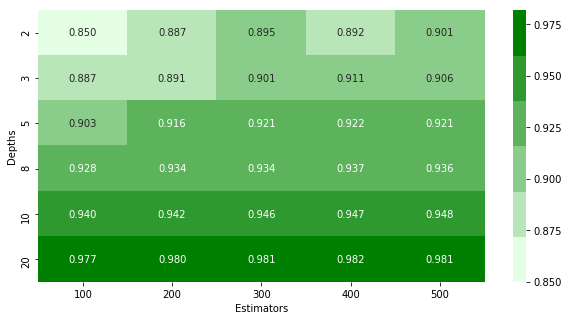

------------------------------ AUC Score for CV data ------------------------------


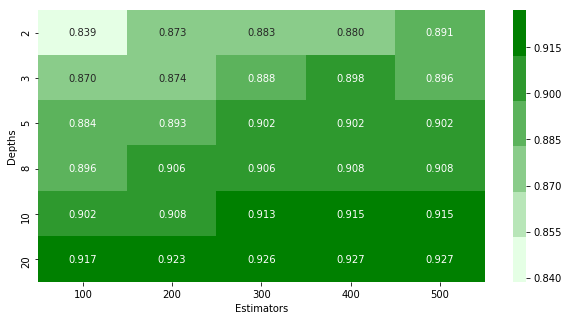

In [27]:
# find optimal depth and optimal estimator
RF_Classifier(bow_train,bow_cv,Y_tr,Y_cv)

### Testing on Test data and Training on BoW for Random Forest

AUC Score for train data 0.9424216551135729
AUC Score for test data 0.9084636095513822
macro f1 score for train data : 0.8165490780177076
macro f1 score for test data : 0.7807271342439894
micro f1 score for train data: 0.8877157360406092
micro f1 score for test data: 0.8720568942898571
hamming loss for train data: 0.11228426395939087
hamming loss for test data: 0.12794310571014292
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.62      0.81      0.70      6472
           1       0.96      0.90      0.93     32928

   micro avg       0.89      0.89      0.89     39400
   macro avg       0.79      0.85      0.82     39400
weighted avg       0.90      0.89      0.89     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.58      0.71      0.64      4649
           1       0.94      0.90      0.92     24317

   micro avg       0.87      0.87      0.87 

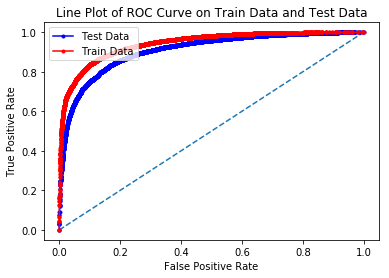

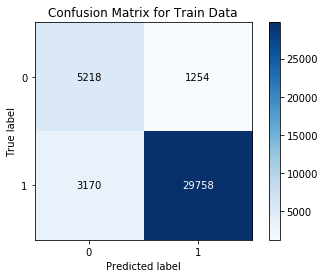

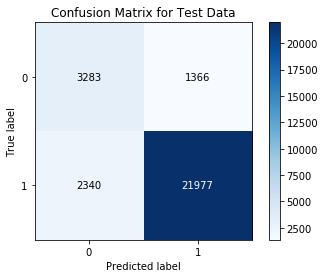

In [35]:
# optimal_depth and optimal_estimator
testing(bow_train,Y_tr,bow_test,Y_test,optimal_depth=8,optimal_estimator=400)

### Training Model on BoW for XGBoost

------------------------------ AUC Score for train data ------------------------------


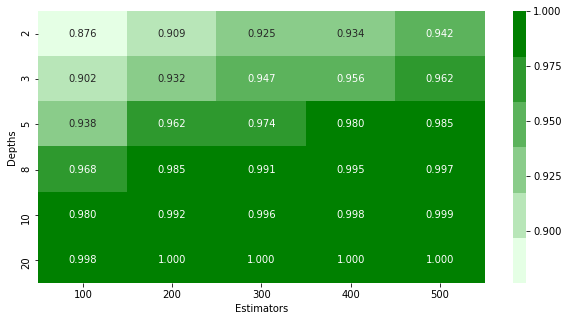

------------------------------ AUC Score for CV data ------------------------------


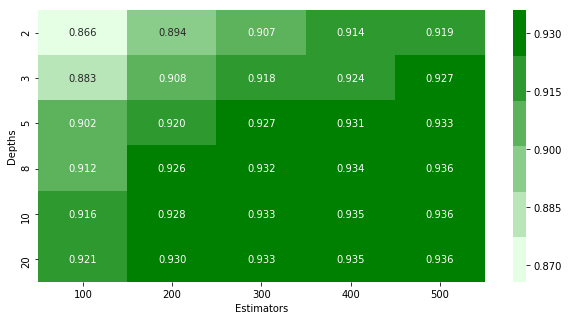

In [26]:
# find optimal depth and optimal estimator
xgb_Classifier(bow_train,bow_cv,Y_tr,Y_cv)

### Testing on Test data and Training on BoW for XGBoost

AUC Score for train data 0.9567841968535161
AUC Score for test data 0.9203990822340111
macro f1 score for train data : 0.8068069266843152
macro f1 score for test data : 0.7641070653658102
micro f1 score for train data: 0.9142385786802031
micro f1 score for test data: 0.8984326451701995
hamming loss for train data: 0.08576142131979696
hamming loss for test data: 0.10156735482980045
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.94      0.51      0.66      6472
           1       0.91      0.99      0.95     32928

   micro avg       0.91      0.91      0.91     39400
   macro avg       0.92      0.75      0.81     39400
weighted avg       0.92      0.91      0.90     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.85      0.45      0.59      4649
           1       0.90      0.98      0.94     24317

   micro avg       0.90      0.90      0.90 

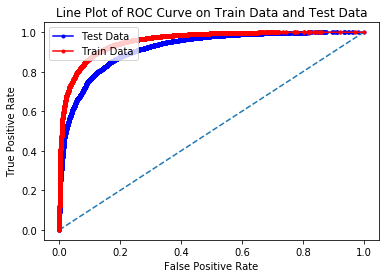

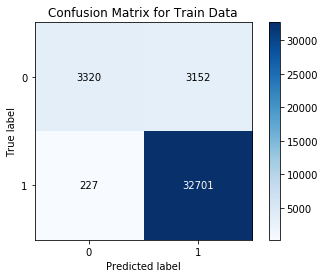

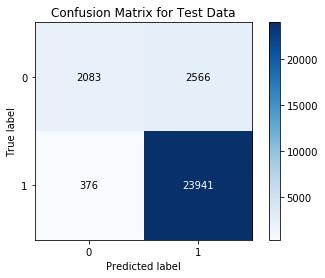

In [36]:
# optimal_depth and optimal_estimator
testing1(bow_train,Y_tr,bow_test,Y_test,optimal_depth=3,optimal_estimator=400)

### Top 20 Features in BoW for Random Forest 

feature_importances	features
0.0335			great          
0.0323			love           
0.0283			disappoint     
0.0175			money          
0.0175			best           
0.0166			return         
0.0145			delici         
0.0127			thought        
0.0125			good           
0.0123			terribl        
0.0120			bad            
0.0119			would          
0.0115			horribl        
0.0112			perfect        
0.0111			wast           
0.0103			nice           
0.0102			away           
0.0100			aw             
0.0099			worst          
0.0098			easi           


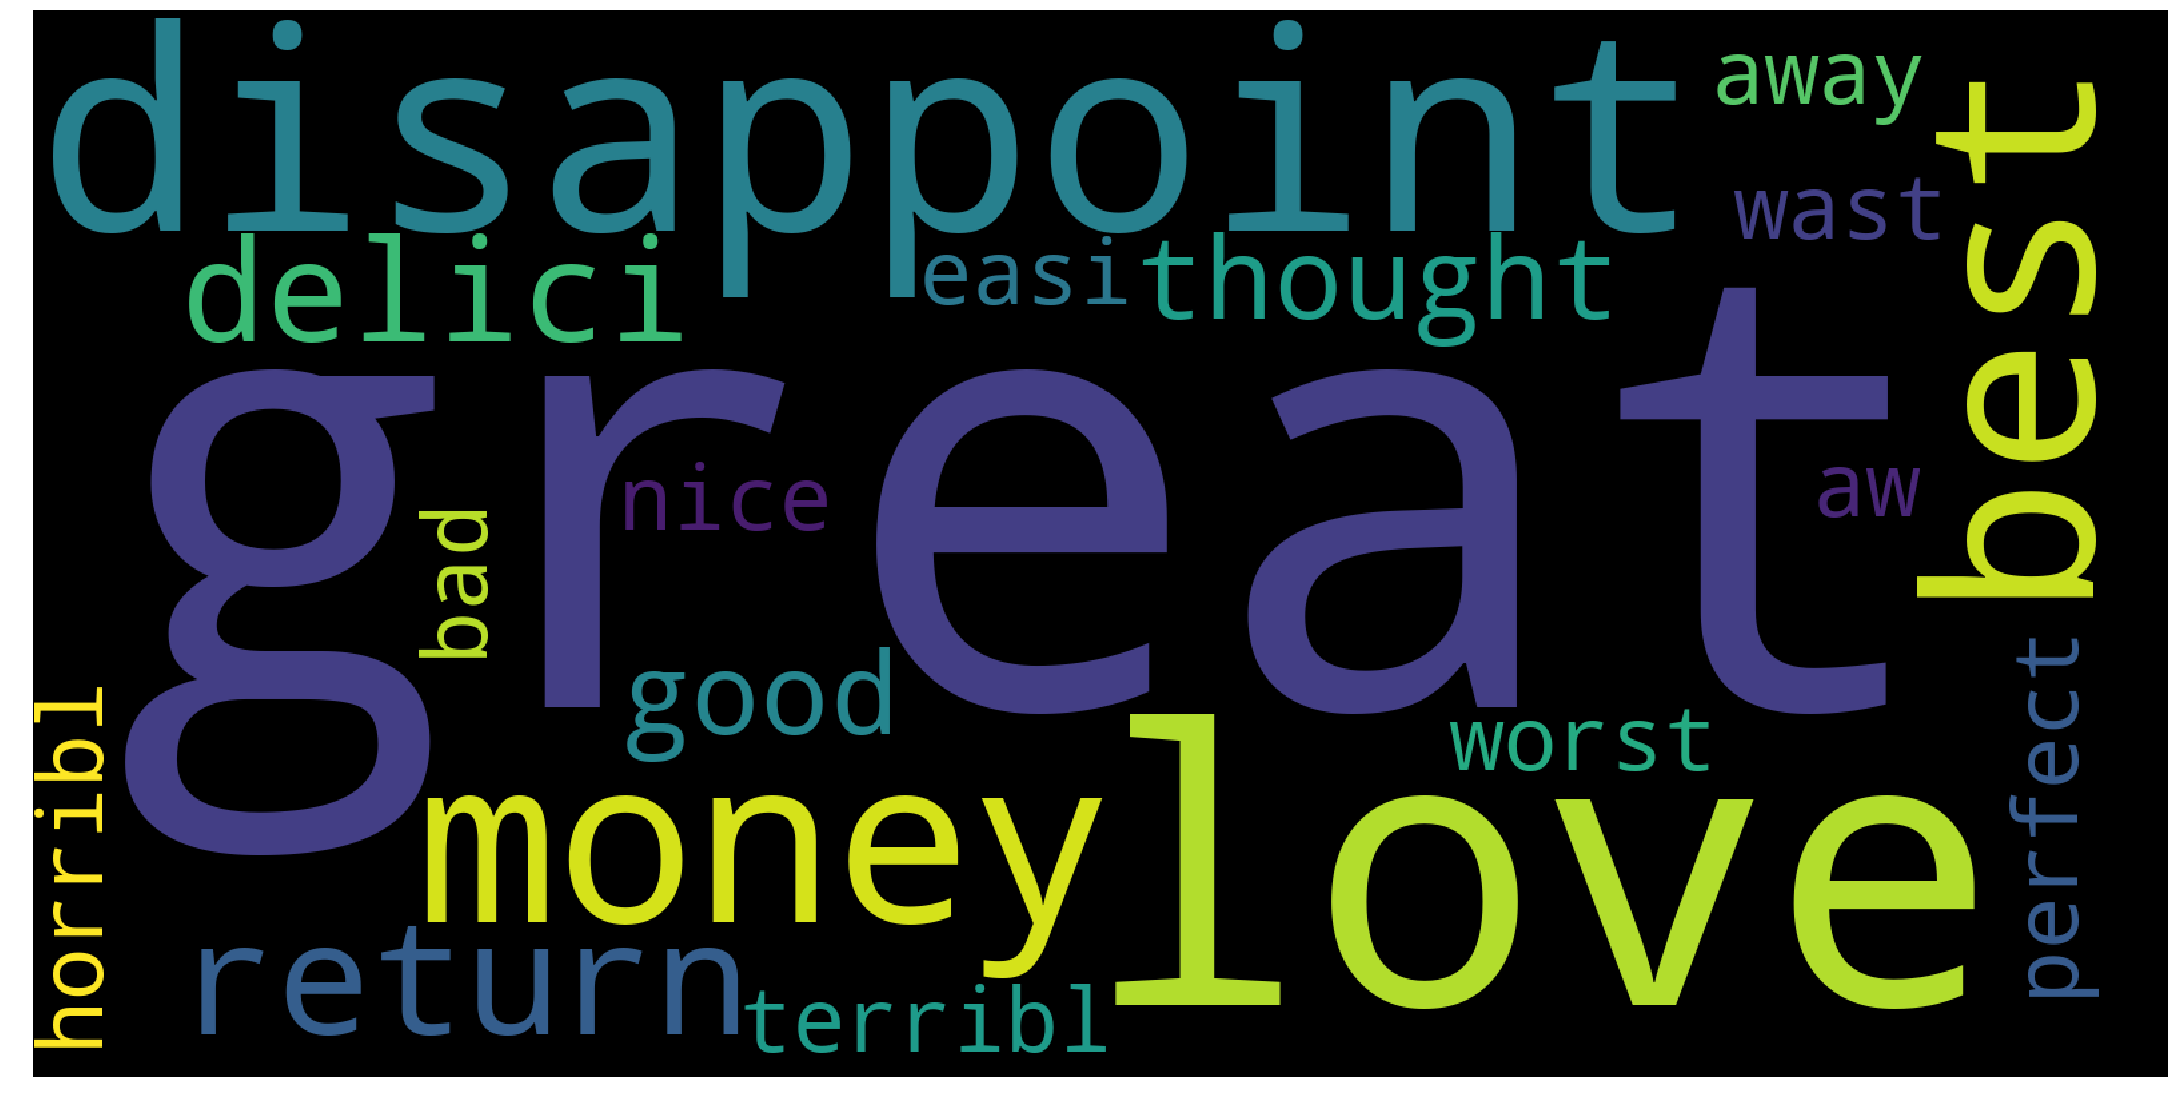

In [54]:
#print top 20 features Random forest classifier
clf = RandomForestClassifier(max_depth =10, n_estimators = 400,class_weight='balanced')
clf.fit(bow_train,Y_tr)
features = imp_feature(count_vect,clf)

### Top 20 Features in BoW for XGBoost 

feature_importances	features
0.0207			tast           
0.0176			good           
0.0169			great          
0.0153			love           
0.0119			product        
0.0115			disappoint     
0.0115			best           
0.0111			like           
0.0107			price          
0.0100			howev          
0.0100			delici         
0.0092			unfortun       
0.0092			flavor         
0.0088			bit            
0.0084			use            
0.0084			nice           
0.0081			thought        
0.0081			perfect        
0.0081			didnt          
0.0077			tri            


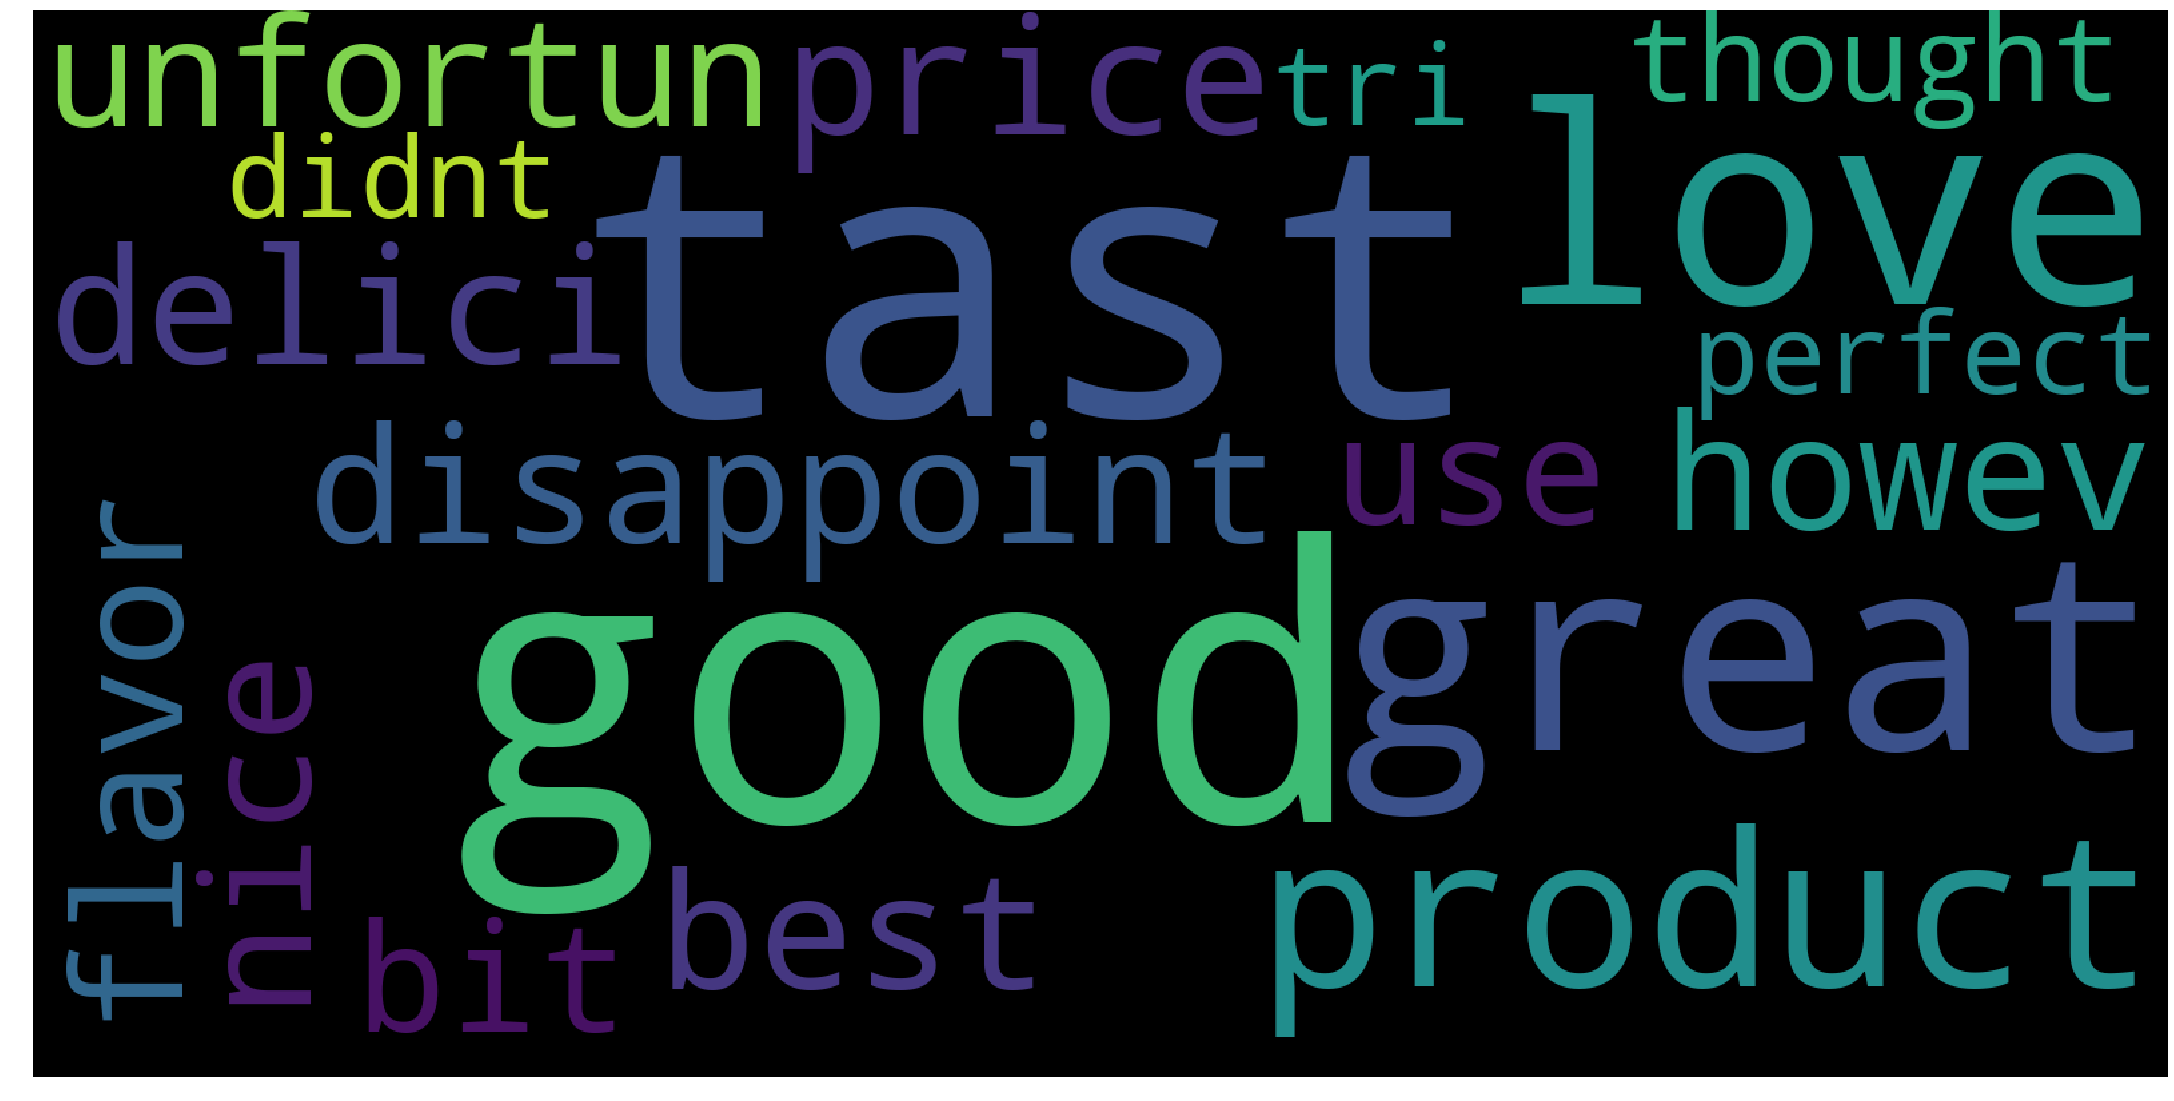

In [55]:
#print top 20 features xgboost classifier
clf = XGBClassifier(n_estimators=400, max_depth=3, scale_pos_weight=1, objective='binary:logistic')
clf.fit(bow_train,Y_tr)
features = imp_feature(count_vect,clf)

##  TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (39400, 642970)
CV Data Size:  (19407, 642970)
Test Data Size:  (28966, 642970)


In [30]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(tfidf_train)
bow_cv = normalizer.transform(tfidf_cv)
bow_test = normalizer.transform(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (39400, 642970)
CV Data Size:  (19407, 642970)
Test Data Size:  (28966, 642970)


### Training Model on TF-IDF for Random Forest 

------------------------------ AUC Score for train data ------------------------------


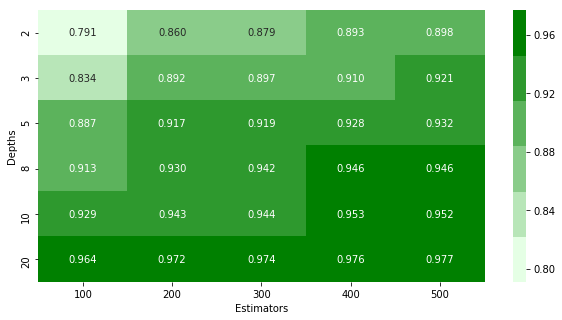

------------------------------ AUC Score for CV data ------------------------------


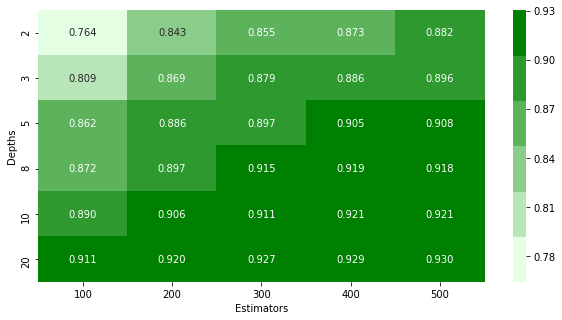

In [31]:
# find optimal depth and optimal estimator
RF_Classifier(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### Testing on Test data and Traing data in TF-IDF for Random Forest

AUC Score for train data 0.9303204008018093
AUC Score for test data 0.9035709310343971
macro f1 score for train data : 0.7982344817895414
macro f1 score for test data : 0.7712343421116483
micro f1 score for train data: 0.8755583756345178
micro f1 score for test data: 0.8653593868673617
hamming loss for train data: 0.12444162436548223
hamming loss for test data: 0.13464061313263825
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.59      0.78      0.67      6472
           1       0.95      0.89      0.92     32928

   micro avg       0.88      0.88      0.88     39400
   macro avg       0.77      0.84      0.80     39400
weighted avg       0.89      0.88      0.88     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.57      0.70      0.62      4649
           1       0.94      0.90      0.92     24317

   micro avg       0.87      0.87      0.87 

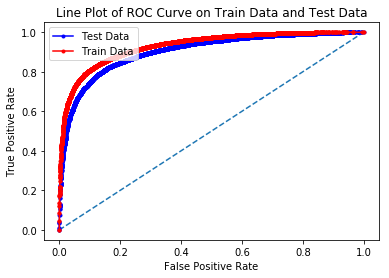

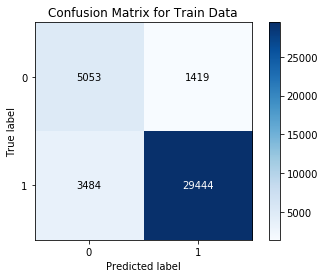

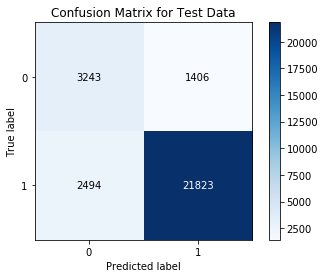

In [32]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_depth=5,optimal_estimator=500)

### Training Model on TF-IDF for XGBoost

------------------------------ AUC Score for train data ------------------------------


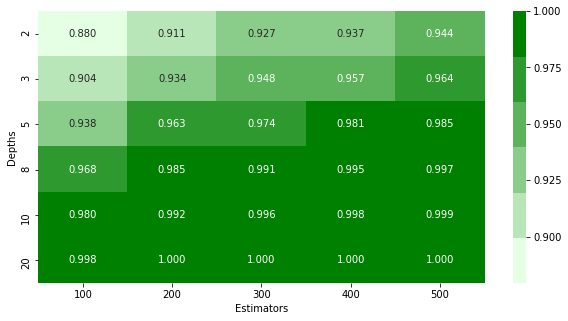

------------------------------ AUC Score for CV data ------------------------------


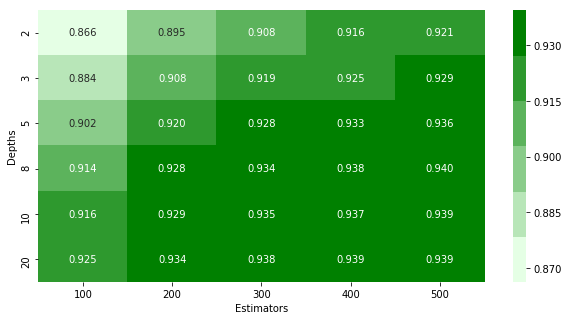

In [33]:
# find optimal depth and optimal estimator
xgb_Classifier(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### Testing on Test data and Traing data in TF-IDF for XGBoost 

AUC Score for train data 0.9567841968535161
AUC Score for test data 0.9203990822340111
macro f1 score for train data : 0.8068069266843152
macro f1 score for test data : 0.7641070653658102
micro f1 score for train data: 0.9142385786802031
micro f1 score for test data: 0.8984326451701995
hamming loss for train data: 0.08576142131979696
hamming loss for test data: 0.10156735482980045
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.94      0.51      0.66      6472
           1       0.91      0.99      0.95     32928

   micro avg       0.91      0.91      0.91     39400
   macro avg       0.92      0.75      0.81     39400
weighted avg       0.92      0.91      0.90     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.85      0.45      0.59      4649
           1       0.90      0.98      0.94     24317

   micro avg       0.90      0.90      0.90 

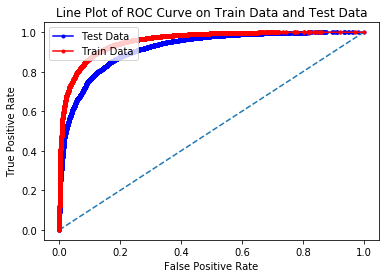

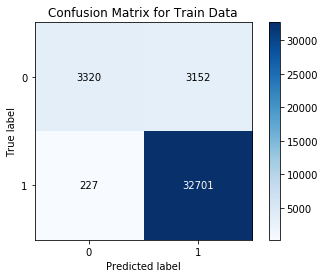

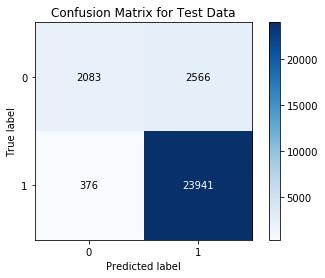

In [45]:
testing1(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_depth=3,optimal_estimator=400)

### Top 20 Features in TF-IDF for Random Forest  

feature_importances	features
0.0450			away           
0.0379			easi           
0.0324			money          
0.0290			would          
0.0273			amaz           
0.0265			one best       
0.0257			descript       
0.0249			mislead        
0.0244			even           
0.0236			alway          
0.0230			box            
0.0211			glad           
0.0183			formula        
0.0182			everi morn     
0.0170			suppos         
0.0158			toler          
0.0151			long           
0.0148			abl            
0.0140			help           
0.0130			buy product    


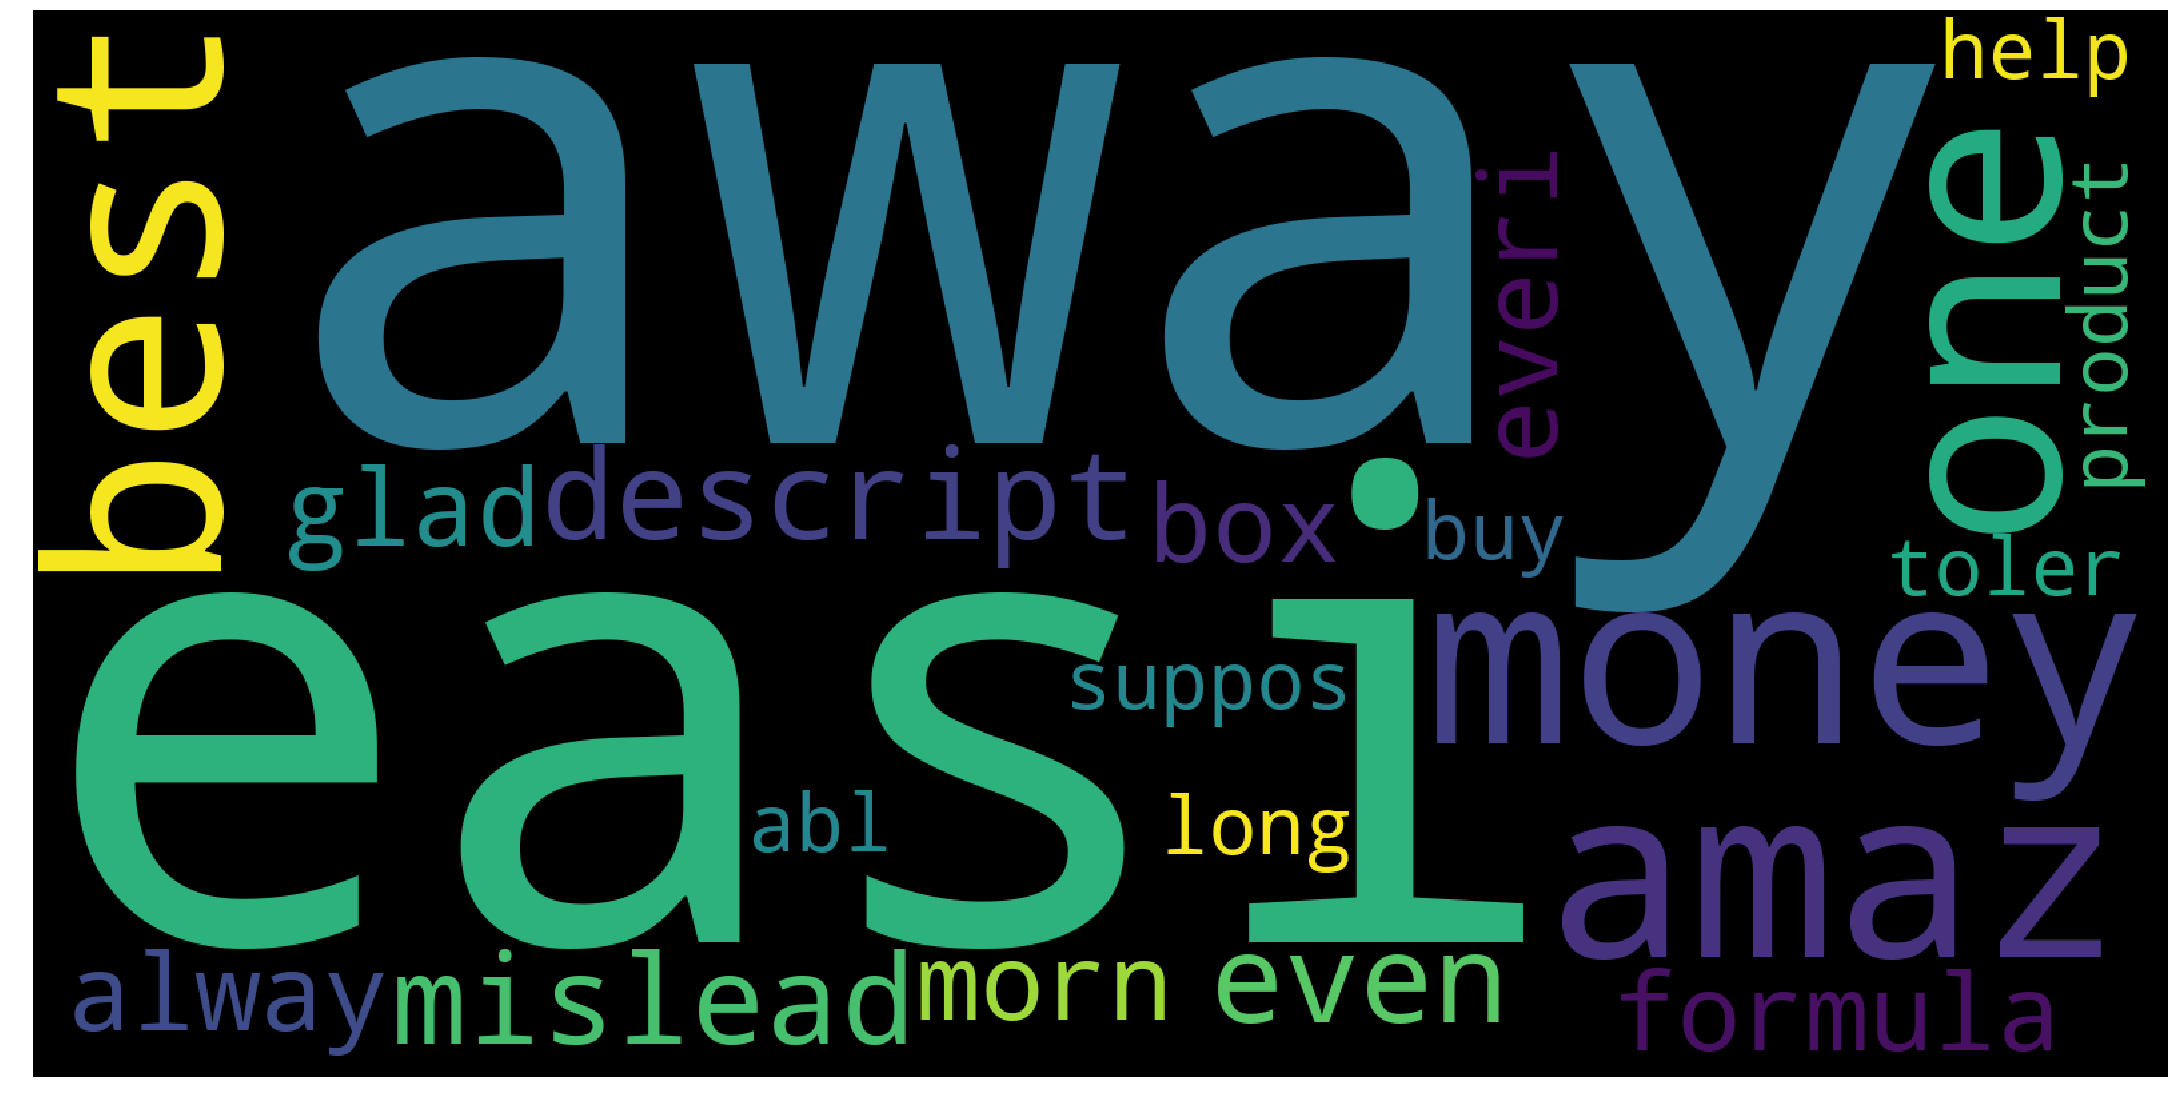

In [51]:
clf = RandomForestClassifier(max_depth =10 , min_samples_split =500, class_weight='balanced')
clf.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf)

### Top 20 Features in TF-IDF for XGBoost  

feature_importances	features
0.0237			tast           
0.0194			great          
0.0190			good           
0.0179			love           
0.0148			like           
0.0128			best           
0.0113			price          
0.0101			disappoint     
0.0101			bit            
0.0093			delici         
0.0089			unfortun       
0.0085			product        
0.0082			would          
0.0082			thought        
0.0082			perfect        
0.0082			nice           
0.0078			one            
0.0078			excel          
0.0070			use            
0.0070			howev          


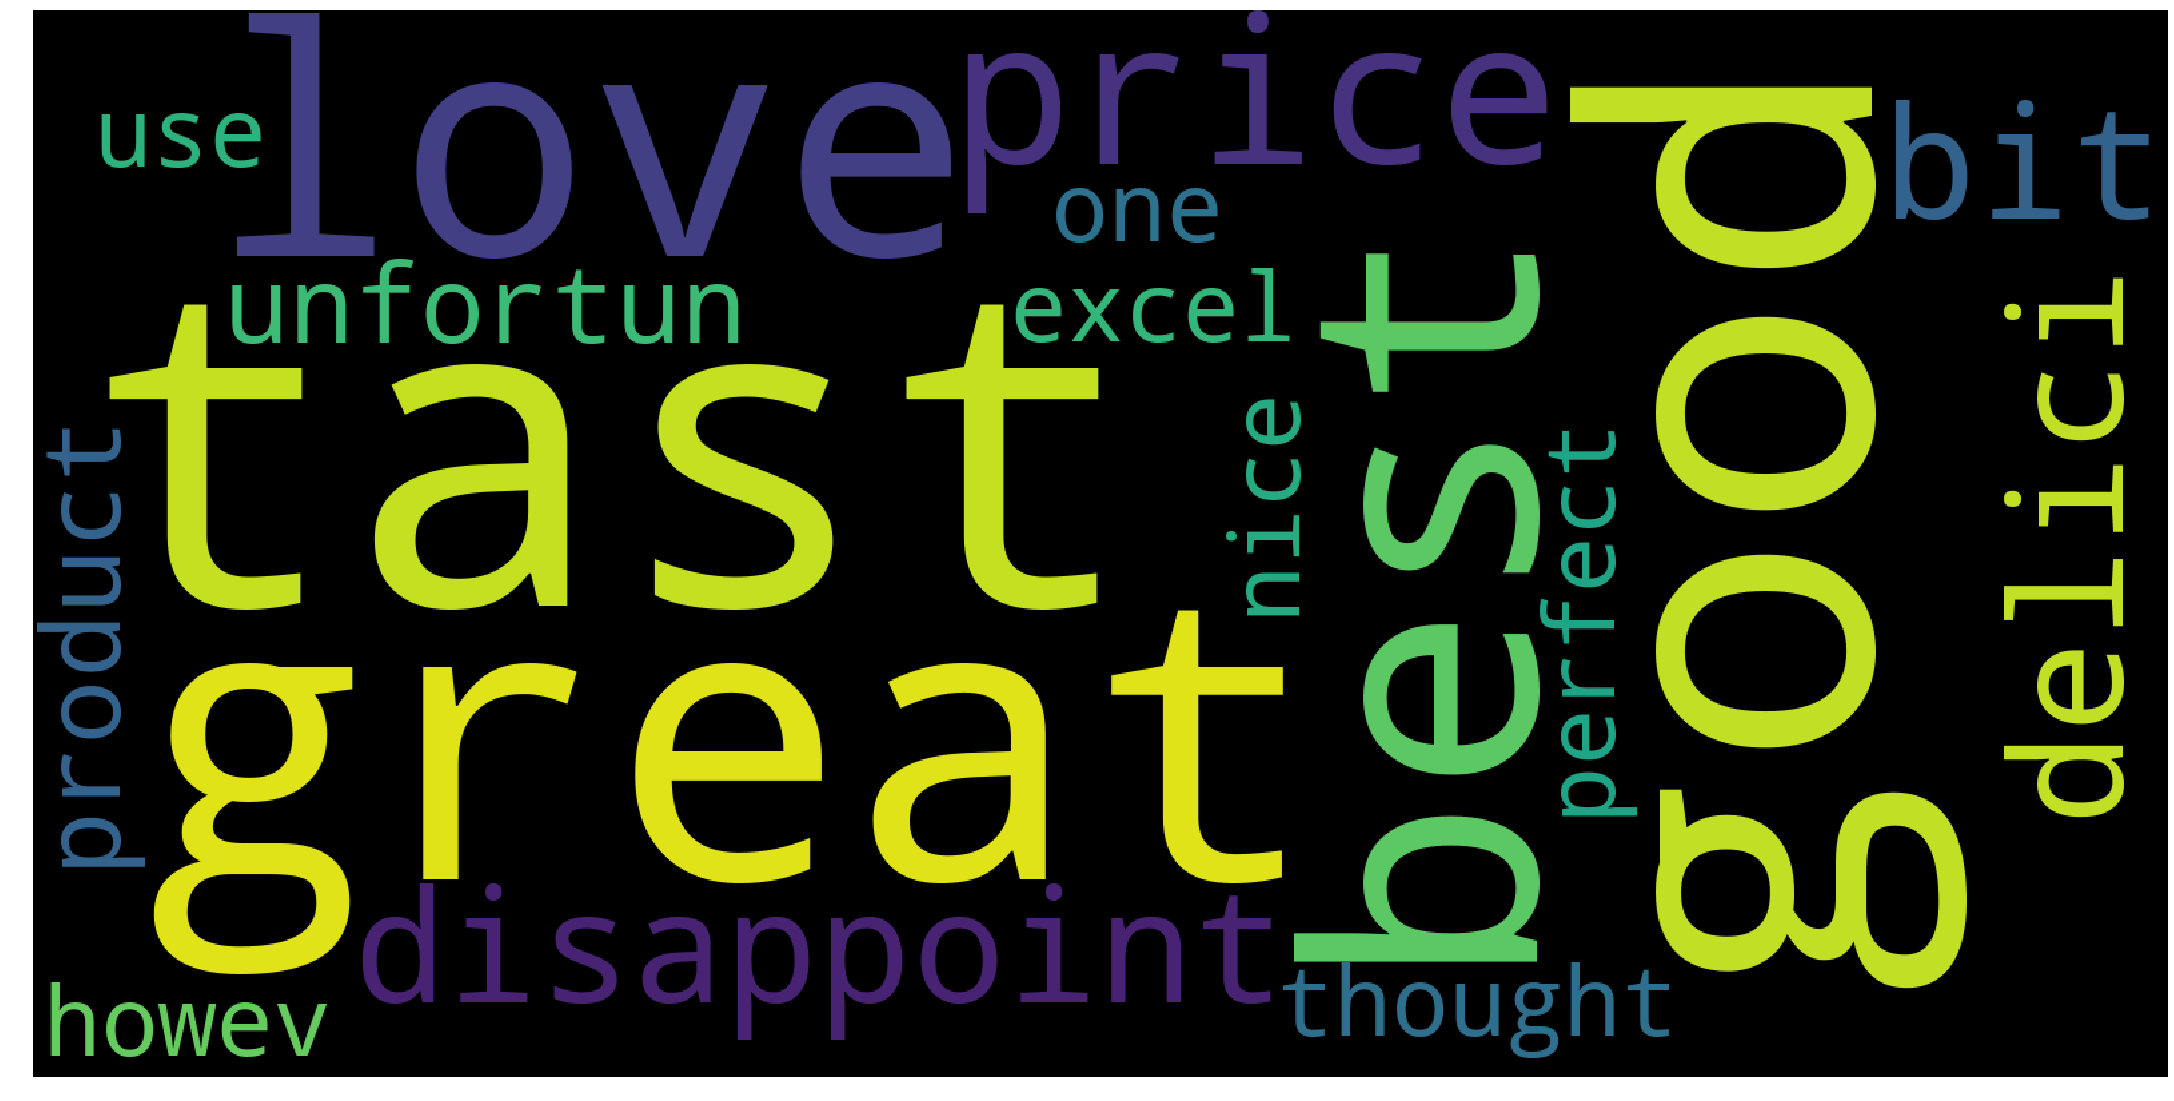

In [47]:
#print top 20 features xgboost classifier
clf = XGBClassifier(n_estimators=400, max_depth=3, scale_pos_weight=1, objective='binary:logistic')
clf.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf)

## Avg W2V

In [56]:
i=0
list_of_sent_train=[]
for sent in X_tr.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [57]:
i=0
list_of_sent_CV=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered_sentence)

In [58]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [59]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [60]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [61]:
train_avgw2v = avg_w2v(list_of_sent_train)

39400
50


In [62]:
cv_avgw2v = avg_w2v(list_of_sent_CV)

19407
50


In [63]:
test_avgw2v = avg_w2v(list_of_sent_test)

28966
50


In [64]:
normalizer = preprocessing.Normalizer()
train_avgw2v = normalizer.fit_transform(train_avgw2v)
cv_avgw2v = normalizer.transform(cv_avgw2v)
test_avgw2v = normalizer.transform(test_avgw2v)

### Training Model on Avg-W2V for Random Forest

------------------------------ AUC Score for train data ------------------------------


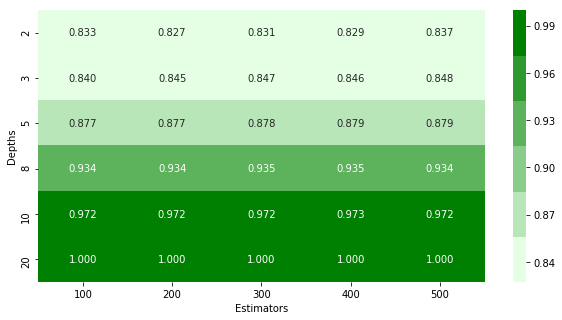

------------------------------ AUC Score for CV data ------------------------------


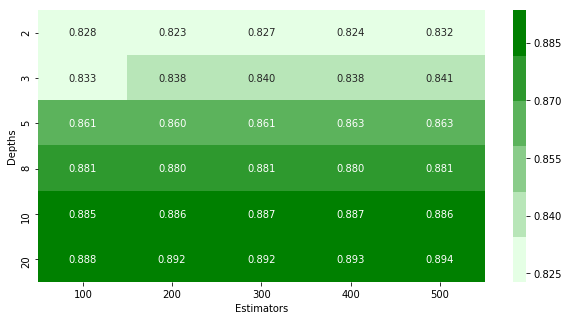

In [65]:
# find optimal depth and optimal estimator
RF_Classifier(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

### Training Model on Avg-W2V for XGBoost

------------------------------ AUC Score for train data ------------------------------


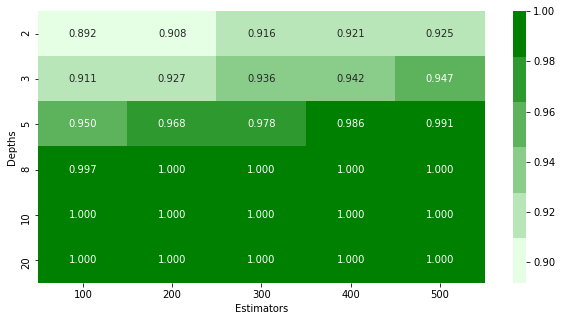

------------------------------ AUC Score for CV data ------------------------------


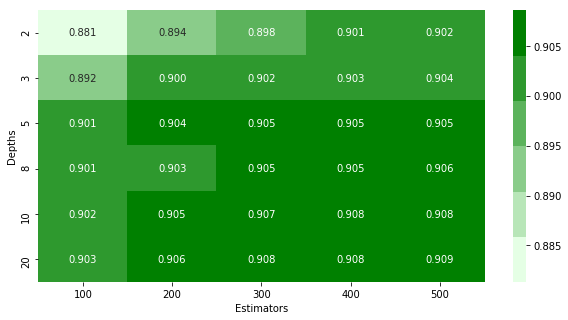

In [66]:
# find optimal depth and optimal estimator
xgb_Classifier(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

### Testing on Test data and Traing data in Avg-W2V for Random Forest

AUC Score for train data 0.8782048751758341
AUC Score for test data 0.8612517068041194
macro f1 score for train data : 0.7171798600087396
macro f1 score for test data : 0.6991464954693318
micro f1 score for train data: 0.7998984771573604
micro f1 score for test data: 0.7880273424014361
hamming loss for train data: 0.2001015228426396
hamming loss for test data: 0.21197265759856385
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.44      0.79      0.56      6472
           1       0.95      0.80      0.87     32928

   micro avg       0.80      0.80      0.80     39400
   macro avg       0.69      0.80      0.72     39400
weighted avg       0.87      0.80      0.82     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.41      0.76      0.54      4649
           1       0.95      0.79      0.86     24317

   micro avg       0.79      0.79      0.79  

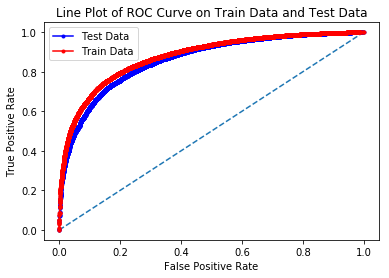

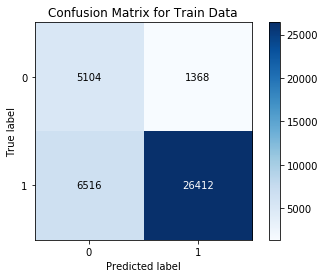

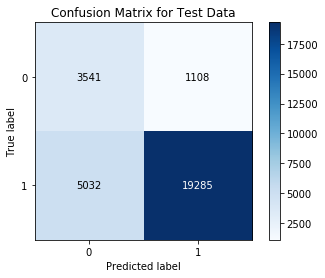

In [67]:
testing(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_depth=5,optimal_estimator=500)

### Testing on Test data and Traing data in Avg-W2V for XGBoost

AUC Score for train data 0.9360265310101614
AUC Score for test data 0.9009220039467054
macro f1 score for train data : 0.7956444583190863
macro f1 score for test data : 0.7512106638527625
micro f1 score for train data: 0.9030964467005076
micro f1 score for test data: 0.8863840364565353
hamming loss for train data: 0.09690355329949239
hamming loss for test data: 0.11361596354346475
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.80      0.54      0.65      6472
           1       0.92      0.97      0.94     32928

   micro avg       0.90      0.90      0.90     39400
   macro avg       0.86      0.76      0.80     39400
weighted avg       0.90      0.90      0.90     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.73      0.47      0.57      4649
           1       0.90      0.97      0.93     24317

   micro avg       0.89      0.89      0.89 

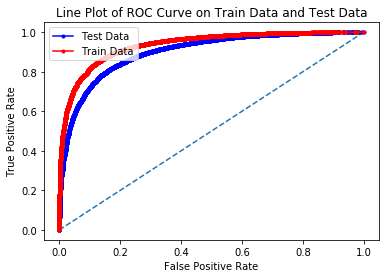

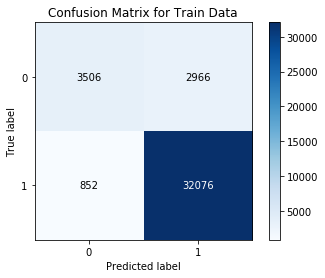

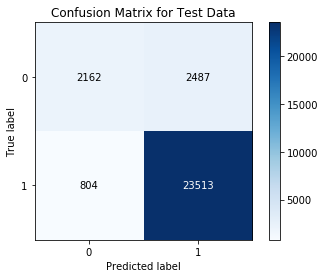

In [68]:
testing1(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_depth=3,optimal_estimator=300)

## TF-IDF Weighted W2V

In [69]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (39400, 23389)
CV Data Size:  (19407, 23389)
Test Data Size:  (28966, 23389)


In [70]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
#return tfidf_sent_vectors_train

39400
50


In [71]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_CV:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
#return tfidf_sent_vectors_CV

19407
50


In [72]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
#return tfidf_sent_vectors_test

28966
50


In [73]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [74]:
normalizer = preprocessing.Normalizer()
train_tfidfw2v = normalizer.fit_transform(train_tfidfw2v)
cv_tfidfw2v = normalizer.transform(cv_tfidfw2v)
test_tfidfw2v = normalizer.transform(test_tfidfw2v)

### Training Model on TFIDF-W2V for Random Forest 

------------------------------ AUC Score for train data ------------------------------


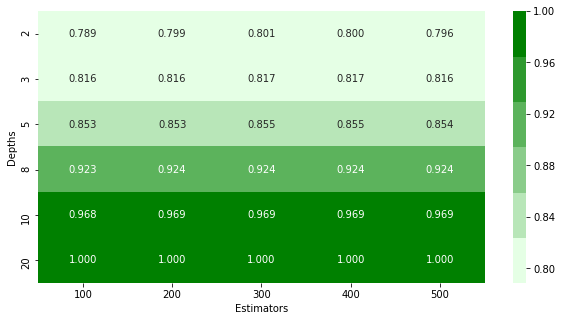

------------------------------ AUC Score for CV data ------------------------------


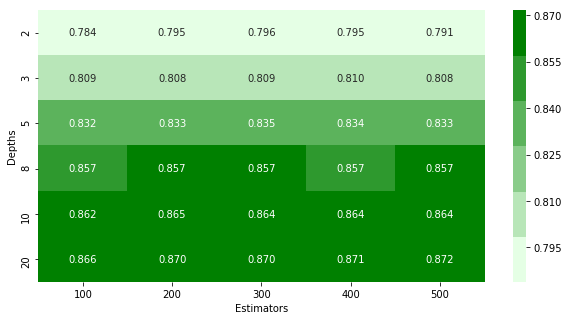

In [75]:
# find optimal depth and optimal estimator
RF_Classifier(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

### Training Model on TFIDF-W2V for XGBoost 

------------------------------ AUC Score for train data ------------------------------


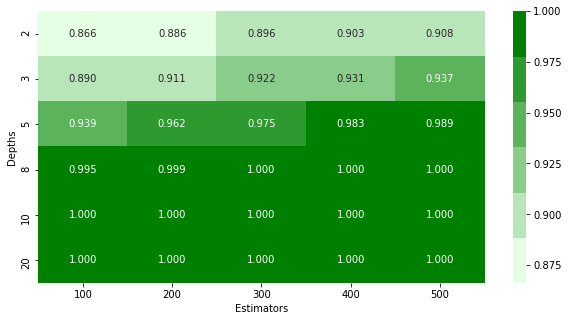

------------------------------ AUC Score for CV data ------------------------------


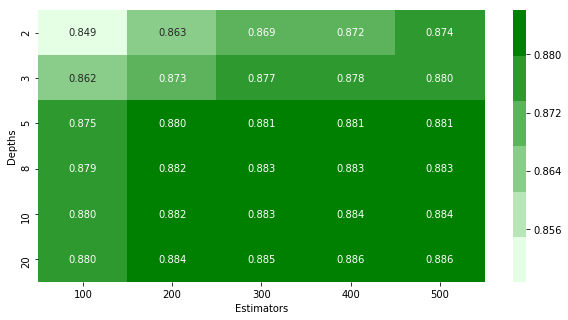

In [76]:
# find optimal depth and optimal estimator
xgb_Classifier(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

### Testing on Test data and Training data in TF-IDF W2V for Random Forest 

AUC Score for train data 0.8549186350771988
AUC Score for test data 0.832943360423505
macro f1 score for train data : 0.7019009975442363
macro f1 score for test data : 0.6846392402403141
micro f1 score for train data: 0.7928934010152284
micro f1 score for test data: 0.7829524269833598
hamming loss for train data: 0.20710659898477157
hamming loss for test data: 0.2170475730166402
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.42      0.73      0.54      6472
           1       0.94      0.80      0.87     32928

   micro avg       0.79      0.79      0.79     39400
   macro avg       0.68      0.77      0.70     39400
weighted avg       0.85      0.79      0.81     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.40      0.70      0.51      4649
           1       0.93      0.80      0.86     24317

   micro avg       0.78      0.78      0.78   

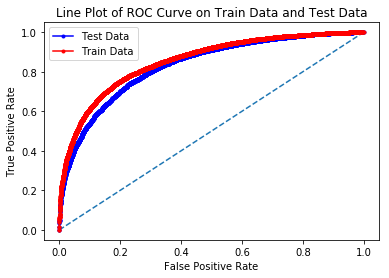

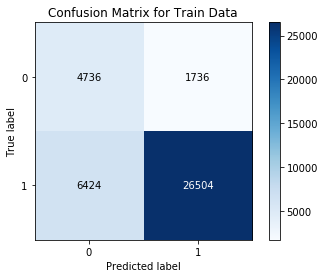

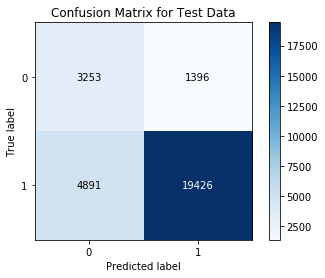

In [77]:
testing(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_depth=5,optimal_estimator=500)

### Testing on Test data and Training data in TF-IDF W2V for XGBoost

AUC Score for train data 0.9108412178055489
AUC Score for test data 0.8734687502534836
macro f1 score for train data : 0.7307807474657917
macro f1 score for test data : 0.6924361136195154
micro f1 score for train data: 0.8832741116751269
micro f1 score for test data: 0.8720568942898571
hamming loss for train data: 0.1167258883248731
hamming loss for test data: 0.12794310571014292
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.79      0.40      0.53      6472
           1       0.89      0.98      0.93     32928

   micro avg       0.88      0.88      0.88     39400
   macro avg       0.84      0.69      0.73     39400
weighted avg       0.87      0.88      0.87     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.72      0.34      0.46      4649
           1       0.88      0.97      0.93     24317

   micro avg       0.87      0.87      0.87  

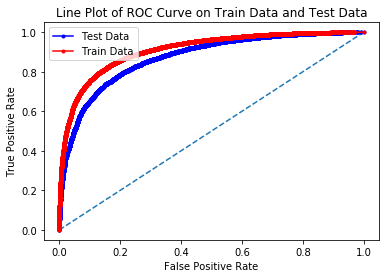

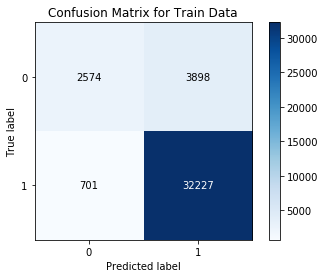

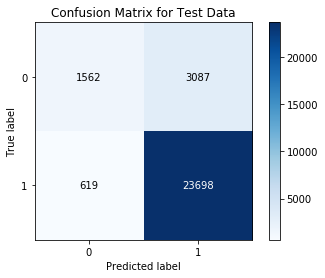

In [78]:
testing1(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_depth=3,optimal_estimator=200)

In [79]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Model","Best Hyper Parameter(Depth)","Best Hyper parameter(n_estimator)","Test Auc Score"]
x.add_row(["BoW","Random Forest",8,400,90.84])
x.add_row(["Tf-Idf","Random Forest",5,500,90.35])
x.add_row(["Avg-W2V","Random Forest",5,500,86.12])
x.add_row(["TfIdf-W2V","Random Forest",5,100,83.29])
x.add_row(["BoW","XGBoost",3,400,92.04])
x.add_row(["Tf-Idf","XGBoost",3,400,92.09])
x.add_row(["Avg-W2V","XGBoost",3,300,90.10])
x.add_row(["TfIdf-W2V","XGBoost",3,200,87.34])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+---------------+-----------------------------+-----------------------------------+----------------+
| Vectorizer |     Model     | Best Hyper Parameter(Depth) | Best Hyper parameter(n_estimator) | Test Auc Score |
+------------+---------------+-----------------------------+-----------------------------------+----------------+
|    BoW     | Random Forest |              8              |                400                |     90.84      |
|   Tf-Idf   | Random Forest |              5              |                500                |     90.35      |
|  Avg-W2V   | Random Forest |              5              |                500                |     86.12      |
| TfIdf-W2V  | Random Forest |              5              |                100                |     83.29      |
|    BoW     |    XGBoost    |              3              |                400                |     92.04      |
|   Tf-Idf   |    XGBoost    |              3              |                400         